# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = False

# Define search period
start_date = '2021-11-19'
end_date = '2021-11-19'

# Define extent
lon_min = 1.5
lon_max = 2.5
lat_min = 41
lat_max = 42

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-19T00:00:00Z', '2021-11-19T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 41 to 42
Longitudes: from 1.5 to 2.5


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple',
                                               CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-19
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 41.2 41.6 42.0
  * longitude   (longitude) float64 1.6 2.0 2.4
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.868e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-05T16:33 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [11]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single',
                                               CAMS_UID = None, CAMS_key = None)
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

2021-12-05 16:33:54,423 INFO Welcome to the CDS
2021-12-05 16:33:54,424 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts


The file does not exist, it will be downloaded.


2021-12-05 16:33:54,439 INFO Request is queued
2021-12-05 16:33:55,449 INFO Request is running
2021-12-05 16:33:59,219 INFO Request is completed
2021-12-05 16:33:59,220 INFO Downloading https://download-0002.copernicus-atmosphere.eu/cache-compute-0002/cache/data4/adaptor.mars_constrained.internal-1638722037.4091325-19807-7-ebc4dc50-4c50-4756-b879-626dcb4717c0.grib to /home/alba/adc-toolbox/data/cams/NO2/NO2-hourly-tc-2021-11-19-2021-11-19.grib (9.3M)
2021-12-05 16:34:00,050 INFO Download rate 11.2M/s


<xarray.Dataset>
Dimensions:     (latitude: 3, longitude: 3, step: 8, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-11-19
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 41.2 41.6 42.0
  * longitude   (longitude) float64 1.6 2.0 2.4
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 5.942e-06 ... 3.96e-06
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-05T16:34 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [12]:
model_total_ds, _ = model_convert_units(model, model_total_ds, sensor,
                                        component_mol_weight, component, model_levels_df,
                                        start_date, end_date, component_nom, apply_kernels,
                                        CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [13]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-19T00:00:00Z', '2021-11-19T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-12-05 16:34:01,241 INFO Found 2 products


Number 0-S5P_NRTI_L2__NO2____20211119T134750_20211119T135250_21255_02_020301_20211119T144631
Number 1-S5P_NRTI_L2__NO2____20211119T120750_20211119T121250_21254_02_020301_20211119T131758
SELECTED
File name: a7487f85-de89-47fc-a855-85574fbd1702
Product name: S5P_NRTI_L2__NO2____20211119T134750_20211119T135250_21255_02_020301_20211119T144631.nc
The file exists, it will not be downloaded again.


In [14]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [15]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 373, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [16]:
match_table = generate_match_table(sensor_ds, model_ds, bbox,  
                                   sensor, component_nom, apply_kernels)
match_table

FOR EST. TIME: 2021-11-19T00:00:00.000000000
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.


delta_time   latitude  \
scanline ground_pixel time       layer                                      
262.0    431.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.025570   
         432.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.022114   
         433.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.018543   
         434.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.014858   
         435.0        2021-11-19 0.0   2021-11-19 13:51:24.961  41.011051   
...                                                        ...        ...   
283.0    438.0        2021-11-19 33.0  2021-11-19 13:51:42.600  42.014156   
         439.0        2021-11-19 33.0  2021-11-19 13:51:42.600  42.009548   
         440.0        2021-11-19 33.0  2021-11-19 13:51:42.600  42.004803   
         441.0        2021-11-19 33.0  2021-11-19 13:51:42.600  41.999905   
         442.0        2021-11-19 33.0  2021-11-19 13:51:42.600  41.994854   

                                        longitude  qa_value  sensor_column  \
scanline ground_pixel time       layer                                       
262.0    431.0        2021-11-19 0.0     1.540752       1.0   6.507713e+15   
         432.0        2021-11-19 0.0     1.628557       1.0   6.411589e+15   
         433.0        2021-11-19 0.0     1.717326       1.0   7.065466e+15   
         434.0        2021-11-19 0.0     1.807078       1.0   8.549124e+15   
         435.0        2021-11-19 0.0     1.897836       1.0   9.066797e+15   
...                                           ...       ...            ...   
283.0    438.0        2021-11-19 33.0    2.065249       1.0   3.581842e+15   
         439.0        2021-11-19 33.0    2.161770       1.0   3.905797e+15   
         440.0        2021-11-19 33.0    2.259432       1.0   5.700694e+15   
         441.0        2021-11-19 33.0    2.358263       1.0   5.976377e+15   
         442.0        2021-11-19 33.0    2.458288       1.0   5.127722e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
262.0    431.0        2021-11-19 0.0                                         0.000026   
         432.0        2021-11-19 0.0                                         0.000026   
         433.0        2021-11-19 0.0                                         0.000029   
         434.0        2021-11-19 0.0                                         0.000034   
         435.0        2021-11-19 0.0                                         0.000035   
...                                                                               ...   
283.0    438.0        2021-11-19 33.0                                        0.000023   
         439.0        2021-11-19 33.0                                        0.000023   
         440.0        2021-11-19 33.0                                        0.000027   
         441.0        2021-11-19 33.0                                        0.000029   
         442.0        2021-11-19 33.0                                        0.000028   

                                        nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time       layer                                                         
262.0    431.0        2021-11-19 0.0                                             0.000015      
         432.0        2021-11-19 0.0                                             0.000015      
         433.0        2021-11-19 0.0                                             0.000017      
         434.0        2021-11-19 0.0                                             0.000018      
         435.0        2021-11-19 0.0                                             0.000019      
...                                                                                   ...      
283.0    438.0        2021-11-19 33.0                                            0.000019      
         439.

## 5. Merge data and calculate difference

In [17]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, sensor, apply_kernels)
merge_table

latitude  longitude  model_column  \
ground_pixel scanline time                                             
431.0        262.0    2021-11-19  41.025566   1.540752  4.347590e+15   
             263.0    2021-11-19  41.074020   1.535052  4.347590e+15   
             264.0    2021-11-19  41.122463   1.529236  4.347590e+15   
             265.0    2021-11-19  41.170895   1.523464  4.347590e+15   
             266.0    2021-11-19  41.219337   1.517665  4.347590e+15   
...                                     ...        ...           ...   
442.0        279.0    2021-11-19  41.801750   2.477959  3.228244e+15   
             280.0    2021-11-19  41.850044   2.473146  3.228244e+15   
             281.0    2021-11-19  41.898296   2.468258  3.228244e+15   
             282.0    2021-11-19  41.946560   2.463209  3.228244e+15   
             283.0    2021-11-19  41.994854   2.458288  3.228244e+15   

                                  sensor_column    difference  
ground_pixel scanline time                                     
431.0        262.0    2021-11-19   6.507713e+15  2.160123e+15  
             263.0    2021-11-19   4.941873e+15  5.942832e+14  
             264.0    2021-11-19   5.028212e+15  6.806221e+14  
             265.0    2021-11-19   5.939859e+15  1.592269e+15  
             266.0    2021-11-19   6.434915e+15  2.087325e+15  
...                                         ...           ...  
442.0        279.0    2021-11-19   5.524996e+15  2.296752e+15  
             280.0    2021-11-19   4.501894e+15  1.273651e+15  
             281.0    2021-11-19   4.238181e+15  1.009937e+15  
             282.0    2021-11-19   4.561901e+15  1.333657e+15  
             283.0    2021-11-19   5.127722e+15  1.899478e+15  

[264 rows x 5 columns]

In [18]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference
count,264.000000,264.000000,2.640000e+02,2.640000e+02,2.640000e+02
mean,41.512203,1.985429,4.936901e+15,7.316648e+15,2.379747e+15
std,0.307767,0.325782,1.468451e+15,3.199735e+15,2.621666e+15
min,40.980751,1.419496,2.609278e+15,2.200136e+15,-2.940916e+15
25%,41.247990,1.704858,3.862884e+15,5.032687e+15,8.657648e+14
50%,41.510941,1.979666,5.643061e+15,6.710046e+15,1.955112e+15
75%,41.777933,2.264937,6.556133e+15,8.569455e+15,3.146662e+15
max,42.042683,2.563264,6.883949e+15,1.979032e+16,1.323418e+16


## 6. Show comparison plots

### Select plot dates

In [19]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-11-19T00:00:00.000000000']


### Select plot extent

In [20]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((1.5, 41), (2.5, 42))


### Compare CAMS and TROPOMI total columns

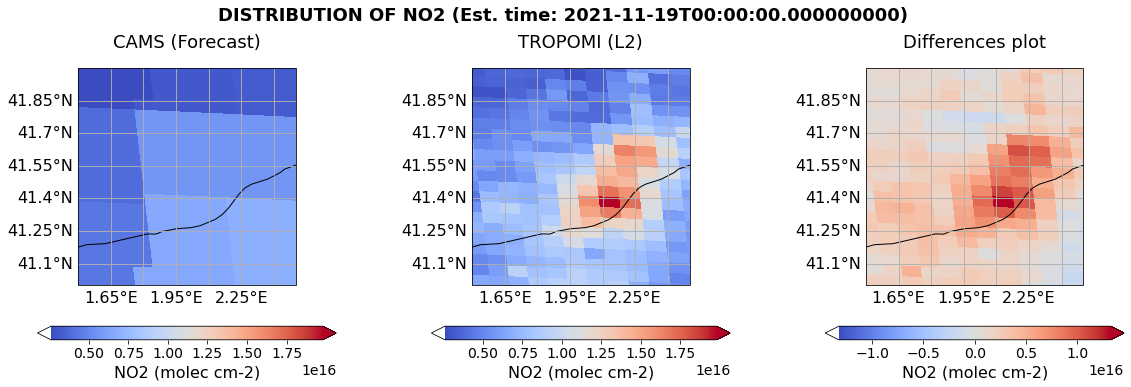

In [30]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Compare CAMS original and averaged total columns

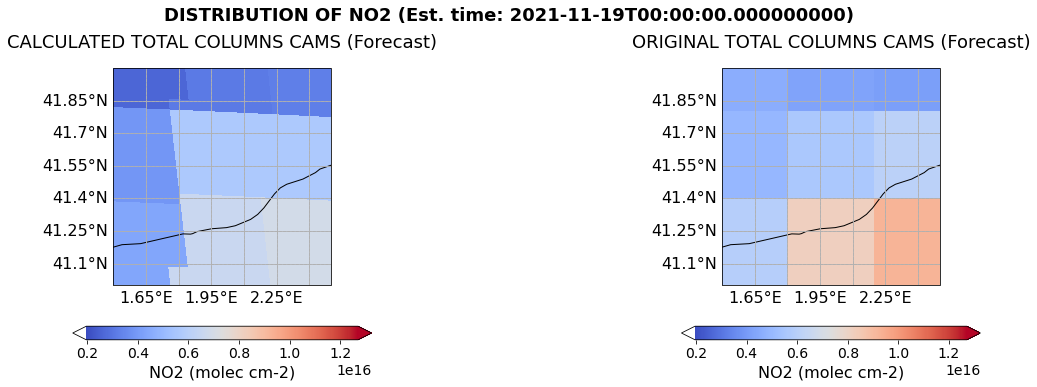

In [31]:
# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1.05, model_type, range_type, projection, color_scale,
                                       vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [23]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

,,,,,ground_pixel,scanline,model_column,sensor_column,difference
lat_search,lon_search,latitude,longitude,time,,,,,
50,60,41.994854,2.458288,2021-11-19,442.0,283.0,3.228244e+15,5.127722e+15,1.899478e+15
4,10,40.980751,2.563264,2021-11-19,442.0,262.0,6.883949e+15,4.418666e+15,-2.465283e+15
20,30,40.980751,2.563264,2021-11-19,442.0,262.0,6.883949e+15,4.418666e+15,-2.465283e+15


## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.26 + (2.97E+15)
Coefficient of determination (R2): 0.38


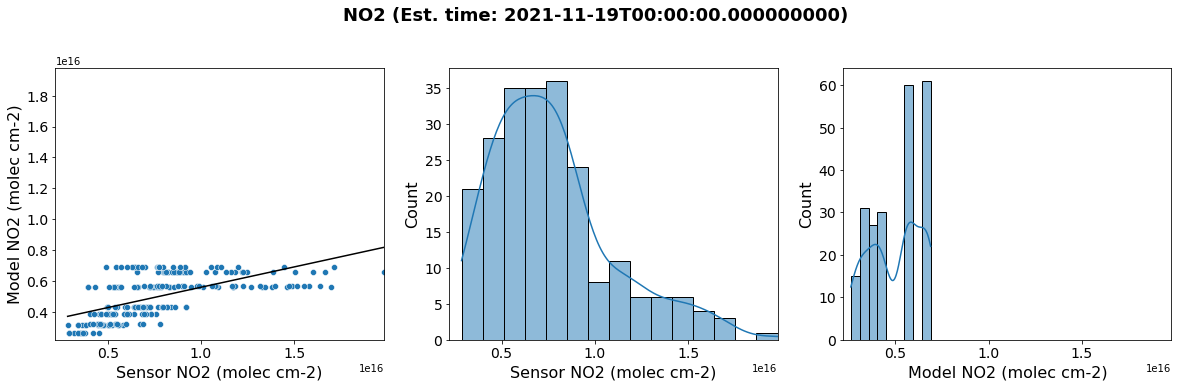

In [24]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [25]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2021-11-19,"((1.5, 41), (2.5, 42))",0.379232,0.263454,2.966493e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.26 + (2.97E+15)
Coefficient of determination (R2): 0.38


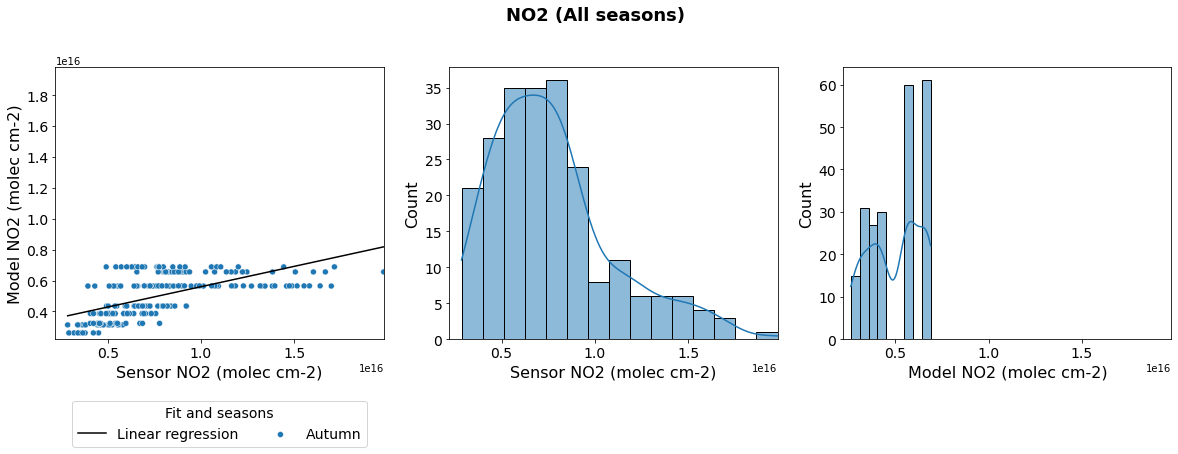

In [26]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [27]:
summary

,Period,Location,Score,Coefficient,Intercept
0,[Autumn],"((1.5, 41), (2.5, 42))",0.379232,0.263454,2.966493e+15


## 10. Scatter plots by country (Google API required!)

In [28]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [29]:
#summary